- ### Planteamiento del problema:

Predecir a partir de medidas diagnósticas si un paciente tiene diabetes o no.

In [1]:
# Se importa el dataset
import pandas as pd

train_data = pd.read_csv("/workspaces/EDA/data/processed/diabetes_train.csv")
test_data = pd.read_csv("/workspaces/EDA/data/processed/diabetes_test.csv")

In [2]:
X_train = train_data.drop("Outcome", axis=1)
X_test = test_data.drop("Outcome", axis=1)

y_train = train_data["Outcome"]
y_test = test_data["Outcome"]

- #### Entrenamiento del modelo

In [1]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state = 42)

In [4]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
y_predict = model.predict(X_test)
y_predict

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [6]:
accuracy = accuracy_score(y_test, y_predict)
print('Precisión')
print(round(accuracy,4))

Precisión
0.7273


Variando hiperparámetros

In [8]:
max_test = max(test)
indice_max_test = test.index(max_test)
n_estimator_max =  n_estimators[indice_max_test]
print(f'El accuracy max del test fue {round(max_test,2)} para {n_estimator_max} árboles.')

El accuracy max del test fue 0.74 para 31 árboles.


Se puede notar que al aumentar el número de árboles, aumenta el accuracy para el test, hasta alcanzar un máximo de 0.74 para 31 árboles. Luego disminuye y permanece prácticamente constante.

- Se varían hiperparámetros del árbol. 

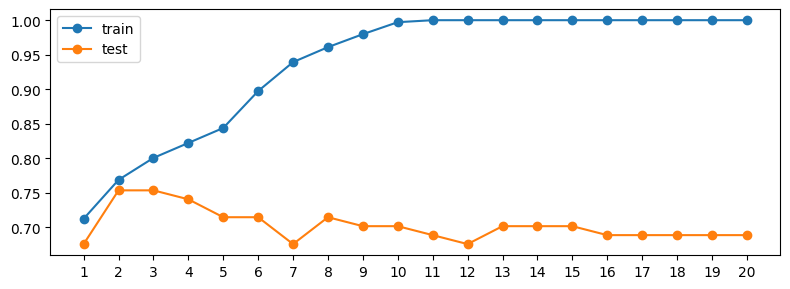

In [9]:
max_depths = list(range(1,21))
training_2 = []
test_2 = []

for i in max_depths:

    model_tree = RandomForestClassifier(max_depth = i, random_state = 42)
    model_tree.fit(X_train, y_train)

    y_train_predict = model_tree.predict(X_train)
    y_train_predict_accuracy = accuracy_score(y_train, y_train_predict)
    training_2.append(y_train_predict_accuracy)

    y_test_predict = model_tree.predict(X_test)
    y_test_predict_accuracy = accuracy_score(y_test, y_test_predict)
    test_2.append(y_test_predict_accuracy)


plt.figure(figsize = (8,3))

plt.plot(max_depths, training_2, 'o-', label = 'train')
plt.plot(max_depths, test_2, 'o-', label = 'test')
plt.xticks(range(1, 21))
plt.legend()
plt.tight_layout()
plt.show()

Se alcanza un máximo de accuracy para un máximo de profundidad de 2, además corresponde con el punto más cercano entre el rendimiento del train y el test.

In [16]:
hyperparams = {
    'n_estimators': list(range(1,52,10)),
    'max_depth' : list(range(1, 8)),
    'min_samples_split' : list(range(2,21,5)),
    'min_samples_leaf' : list(range(1, 11, 3)),
}

In [17]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = model, param_grid = hyperparams, scoring = 'accuracy', n_jobs = -1, cv = 5)

In [18]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 4, 7, 10],
                         'min_samples_split': [2, 7, 12, 17],
                         'n_estimators': [1, 11, 21, 31, 41, 51]},
             scoring='accuracy')

In [20]:
grid_search.best_params_

{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 21}

In [21]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=21, random_state=42)

In [22]:
y_predic_best = best_model.predict(X_test)

In [30]:
accuracy2 = accuracy_score(y_test, y_predic_best)
print(f"Precisión: {accuracy2}")
print(f'La mejoría con hiperparámetros fue de: {round(100*((accuracy2 - accuracy)/accuracy),2)}%')

Precisión: 0.7142857142857143
La mejoría con hiperparámetros fue de: 3.77%


In [24]:
y_prueba = best_model.predict(X_train)
accuracy_score(y_train, y_prueba)

0.8914616497829233

El Modelo Decision Tree tuvo un mejor accuracy que el Random Forest, sin embargo, se logró con hiperparámetros una mejora del rendimiento de aprox. 4%.

In [39]:
from pickle import dump

dump(best_model, open("../models/best_model_randomforest_classifier.sav", "wb"))